# Unit Testing Optimisation

## *BE CAREFUL*

The convolution function used is fast, but flips the kernel/filter along its axis. This may result in weird effects when using non-Gaussian or non-additive noise, so beware.

## Importing the Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
import scipy.io as io
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

## Defining SE Covariance

In [3]:
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

In [4]:
Vec_SE = jit(vmap(vmap(Squared_exp, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

## Creating Test Data

In [5]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [6]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [7]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 50.0

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.1, (k+1,)).astype(np.float64)

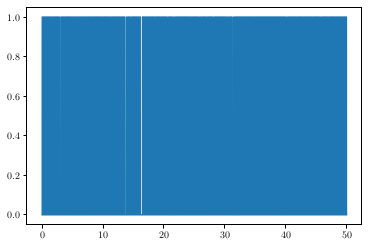

In [8]:
plt.plot(xtime, xtest)

### True Filter

In [9]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 5.0

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1)

# True filter mean
mu_true = np.zeros(n + 1)
# True filter variance
sig_true = 1.0
# True filter length scale
ell_true = 0.4

cov_true = Vec_SE(ftime, ftime, sig_true, ell_true)
chol_true = np.linalg.cholesky(cov_true + 1e-6 * np.eye(n + 1))

ftrue = mu_true + chol_true @ random.normal(subkeyf, (n + 1, ))

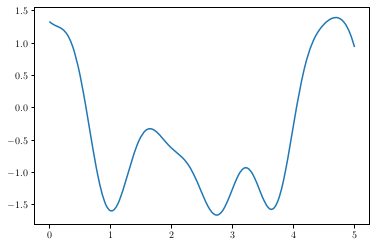

In [10]:
plt.plot(ftime, ftrue)

### True Noise

In [11]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 3.0

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

### Output

In [12]:
x_pad = np.asarray([[np.append(np.zeros(n), xtest)]])
kernel1 = np.asarray([[ftrue[::-1]]])

dn = lax.conv_dimension_numbers(x_pad.shape, kernel1.shape,
                                ('NCW', 'IOW', 'NCW'))                                              

out = lax.conv_general_dilated(x_pad,   # lhs = image tensor
                               kernel1, # rhs = conv kernel tensor
                               (1,),   # window strides
                               'VALID', # padding mode
                               (1,),   # lhs/image dilation
                               (1,),   # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation  

ynonoise = np.convolve(np.append(np.zeros(n), xtest), ftrue, mode='valid')

ytest = out[0,0] + noise_vec

ytime = np.linspace(0.0, x_maxt, k + 1)

In [13]:
# Showing equals the raw convolution
ytruetest = ynonoise + noise_vec

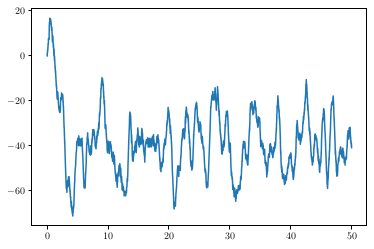

In [14]:
plt.plot(ytime, ytest)

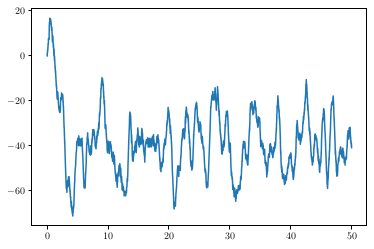

In [15]:
plt.plot(ytime, ytruetest)

## Variational Inference

### ELBO

#### Kl Divergence Term

In [16]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return 0.5 * (- jnp.sum(jnp.log(jnp.diag(L_Matrix) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Log-Likelihood

In [17]:
@partial(jit, static_argnums = (2,3, ))
def Log_Likelihood(F_Test, Sigma_n, K, DN, Y_Test, X_Pad):

  Mean = lax.conv_general_dilated(X_Pad,   # lhs = image tensor
                                F_Test, # rhs = conv kernel tensor
                                (1,),   # window strides
                                'VALID', # padding mode
                                (1,),   # lhs/image dilation
                                (1,),   # rhs/kernel dilation
                                DN)     # dimension_numbers = lhs, rhs, out dimension permutation    
  
  return - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                  jnp.sum((Y_Test - Mean[0,0])**2)/(Sigma_n ** 2))

In [18]:
Vec_LL = jit(vmap(Log_Likelihood, in_axes = [0, None, None, None, None, None]),
             static_argnums = (2,3,))

#### Expected Log-Likelihood

In [19]:
@partial(jit, static_argnums = range(6,11))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, Number_F,
                  M, N, K, DN, Y_Test, X_Pad, F_Time, Subkey):

  K_MM = Vec_SE(Z_Vector, Z_Vector, Sigma_f, Ell)
  K_MN = Vec_SE(Z_Vector, F_Time, Sigma_f, Ell)
  C = jnp.linalg.cholesky(K_MM + 1e-6 * jnp.eye(M)) 
  K_NN = Vec_SE(F_Time, F_Time, Sigma_f, Ell)
  
  B = jsc.linalg.solve_triangular(C, K_MN, lower = True)

  Mu_q = V_Vector @ B
  V_q = K_NN + B.T @ (L_Matrix @ L_Matrix.T - jnp.eye(M)) @ B

  Chol_Vq = jnp.linalg.cholesky(V_q + 1e-6 * jnp.eye(N + 1))

  F_Samples = Mu_q + random.normal(Subkey, (Number_F, 1, 1, N + 1)) @ Chol_Vq.T

  Likelihoods = Vec_LL(F_Samples, Sigma_n, K, DN, Y_Test, X_Pad)

  return jnp.mean(Likelihoods)

In [20]:
test_number_f = 100
test_m = int(1000)
test_key = random.PRNGKey(0)
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m = np.zeros(test_m)
test_l_mm = np.eye(test_m)

In [21]:
print(Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_number_f, test_m, n, k, dn, ytest, x_pad, ftime, test_key))

-3755217848.57784


#### ELBO

In [22]:
@partial(jit, static_argnums = range(7, 12))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, Number_F,
         M, N, K, DN, Y_Test, X_Pad, F_Time, Subkey):

  Square_Frac = Z_Fractions ** 2.0
  Z_Vector = ((Square_Frac) / jnp.max(Square_Frac)) * F_Time[-1]

  D = jnp.diag(jnp.exp(L_Diag))

  L_Matrix = (D + jnp.zeros((M, M))).at[jnp.tril_indices(M, -1)].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix,
                      Number_F, M, N, K, DN, Y_Test, X_Pad, F_Time, Subkey)
  
  return (KL-Exp)/(K + 1)

In [23]:
test_number_f = 100
test_m = 200
test_key = random.PRNGKey(0)
test_sigma_f = 2.0
test_ell_f = 0.7
test_sigma_n = 0.01
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m1 = np.zeros(test_m)
test_v_m2 = 5.0 * np.ones(test_m)
test_l_diag = np.ones(test_m)
test_l_odiag = np.tril(np.zeros((test_m, test_m)), -1)[np.tril_indices(test_m, -1)]

In [24]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m2, test_l_diag, test_l_odiag, test_number_f, test_m, n, k, dn, ytest, x_pad, ftime, test_key))

256805934514.67496


In [25]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(7)), static_argnums = range(7, 12))

In [26]:
%%capture
print(Grad_Bound(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m2, test_l_diag, test_l_odiag, test_number_f, test_m, n, k, dn, ytest, x_pad, ftime, test_key))

In [27]:
%timeit -n 20 -r 10 test_grad = Grad_Bound(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m2, test_l_diag, test_l_odiag, test_number_f, test_m, n, k, dn, ytest, x_pad, ftime, test_key)

49.4 ms ± 2.03 ms per loop (mean ± std. dev. of 10 runs, 20 loops each)
